N19DCAT015 - Le Ngoc Kim Duyen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from collections import OrderedDict
import sklearn.metrics as metrics

# START: DATA GATHERING

In [2]:
# Các thuộc tính của dataset
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
             "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
             "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
             "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
             "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [3]:
# Load dataset
origin_train_dataFrame = pd.read_csv("NSL_KDD_Train.csv", header=None, names=col_names)
origin_test_dataFrame = pd.read_csv("NSL_KDD_Test.csv", header=None, names=col_names)
# origin_train_dataFrame.drop("score",axis=1,inplace=True)
# origin_test_dataFrame.drop("score",axis=1,inplace=True)
print(origin_train_dataFrame.shape)
print(origin_test_dataFrame.shape)

(125973, 42)
(22544, 42)


Nhóm các features vào 3 nhóm

In [4]:
# nominal features: 2 - 3 - 4
# binary features: 7 - 12 - 14 - 15 - 21
# Còn lại là numeric features
nominal_features = ["protocol_type", "service", "flag"]
binary_features = ["land", "logged_in", "root_shell",
                   "su_attempted", "is_host_login", "is_guest_login"]
numeric_features = []
for feature in col_names:
    if ((feature not in nominal_features) and (feature not in binary_features) and (feature != "label")):
        numeric_features.append(feature)

In [5]:
# Liệt kê các features theo từng nhóm
print("Nominal feature (", len(nominal_features), "): ", nominal_features, sep="")
print("Binary features (", len(binary_features), "): ", binary_features, sep="")
print("Numeric features (", len(numeric_features), "): ", numeric_features, sep="")

Nominal feature (3): ['protocol_type', 'service', 'flag']
Binary features (6): ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
Numeric features (32): ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


Chia lại các record vào 4 phân lớp tấn công

In [6]:
# Xem sự phân phối các subclass
print(origin_train_dataFrame["label"].unique())
print(origin_test_dataFrame["label"].unique())

trainLabels = origin_train_dataFrame["label"].tolist()
testLabels = origin_test_dataFrame["label"].tolist()

differentLabels = list(set(testLabels) - set(trainLabels))
print(differentLabels)
# N19DCAT015 - Le Ngoc Kim Duyen

['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']
['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'teardrop' 'rootkit' 'xlock' 'perl' 'land' 'xsnoop' 'sqlattack'
 'ftp_write' 'imap' 'udpstorm' 'phf']
['snmpguess', 'sendmail', 'processtable', 'named', 'xterm', 'udpstorm', 'mscan', 'snmpgetattack', 'mailbomb', 'httptunnel', 'xlock', 'saint', 'xsnoop', 'sqlattack', 'apache2', 'worm', 'ps']


In [7]:
# Trước tiên cần phải liệt kê danh sách các subclass của 4 phân lớp DoS, Probe, U2R, R2L
# Tấn công DoS
label_DoS = ['apache2', 'back', 'land', 'neptune', 'mailbomb',
             'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
# Tấn công thu thập thông tin
label_Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
# Tấn công chiếm quyền, leo thang đặc quyền
label_U2R = ['buffer_overflow', 'loadmodule',
             'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
# Tấn công kết nối truy cập từ xa
label_R2L = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf',
             'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']

Tách column label thành labels2 (normal - attack) và labels5 (normal - DoS, Probe, R2L, U2R)

In [8]:
attack_labels = []
attack_labels.extend(label_DoS)
attack_labels.extend(label_Probe)
attack_labels.extend(label_U2R)
attack_labels.extend(label_R2L)

In [9]:
# Đối với TRAIN DATASET
origin_train_dataFrame.rename(columns={"label": "labels2"}, inplace=True)
trainLabels2Column = origin_train_dataFrame["labels2"].tolist()
origin_train_dataFrame["labels5"] = trainLabels2Column
origin_train_dataFrame["labels2"].replace(attack_labels, "attack", inplace=True)


In [10]:
# Đối với TEST DATASET
origin_test_dataFrame.rename(columns={"label": "labels2"}, inplace=True)
testLabels2Column = origin_test_dataFrame["labels2"].tolist()
origin_test_dataFrame["labels5"] = testLabels2Column
origin_test_dataFrame["labels2"].replace(attack_labels, "attack", inplace=True)


In [11]:
print(origin_train_dataFrame["labels2"].unique())
print(origin_train_dataFrame["labels5"].unique())
print()
print(origin_test_dataFrame["labels2"].unique())
print(origin_test_dataFrame["labels5"].unique())

['normal' 'attack']
['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']

['attack' 'normal']
['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'teardrop' 'rootkit' 'xlock' 'perl' 'land' 'xsnoop' 'sqlattack'
 'ftp_write' 'imap' 'udpstorm' 'phf']


In [12]:
# Đối với TRAIN DATASET
# Chia các record vào DoS
origin_train_dataFrame["labels5"].replace(label_DoS, "DoS", inplace=True)
# Chia các record vào Probe
origin_train_dataFrame["labels5"].replace(label_Probe, "Probe", inplace=True)
# Chia các record vào U2R
origin_train_dataFrame["labels5"].replace(label_U2R, "U2R", inplace=True)
# Chia các record vào R2L
origin_train_dataFrame["labels5"].replace(label_R2L, "R2L", inplace=True)

# Đối với TEST DATASET
# Chia các record vào DoS
origin_test_dataFrame["labels5"].replace(label_DoS, "DoS", inplace=True)
# Chia các record vào Probe
origin_test_dataFrame["labels5"].replace(label_Probe, "Probe", inplace=True)
# Chia các record vào U2R
origin_test_dataFrame["labels5"].replace(label_U2R, "U2R", inplace=True)
# Chia các record vào R2L
origin_test_dataFrame["labels5"].replace(label_R2L, "R2L", inplace=True)

normal    67343
attack    58630
Name: labels2, dtype: int64


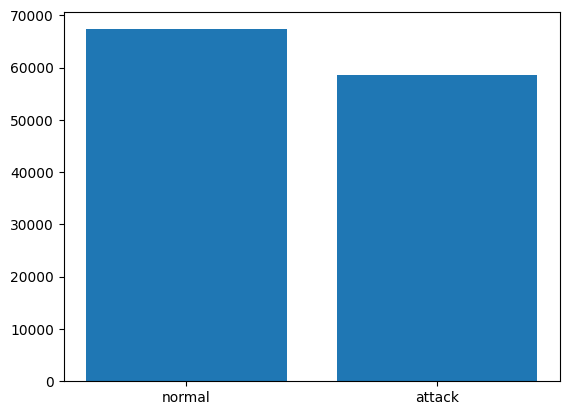

In [13]:
# Xem sự phân phối theo normal - attack
print(origin_train_dataFrame["labels2"].value_counts())
# Vẽ biểu đồ phân phối theo normal - attack
x_label_distribute = np.array(
    origin_train_dataFrame["labels2"].value_counts().index.tolist())
y_label_distribute = np.array(
    origin_train_dataFrame["labels2"].value_counts().values.tolist())
plt.bar(x_label_distribute, y_label_distribute)
plt.show()

normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: labels5, dtype: int64


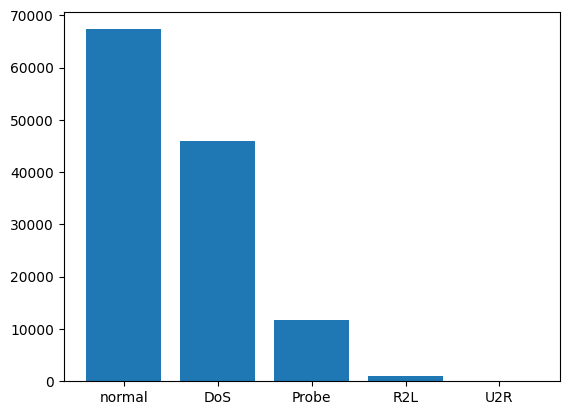

In [14]:
# Xem lại sự phân phối theo lớp tấn công
print(origin_train_dataFrame["labels5"].value_counts())
# Vẽ biểu đồ phân phối theo lớp tấn công
x_label_distribute = np.array(
    origin_train_dataFrame["labels5"].value_counts().index.tolist())
y_label_distribute = np.array(
    origin_train_dataFrame["labels5"].value_counts().values.tolist())
plt.bar(x_label_distribute, y_label_distribute)
plt.show()

# END: DATA GATHERING

# START: DATA PROCESSING

In [15]:
# N19DCAT015 - Le Ngoc Kim Duyen
# Trong dataset nsl-kdd có 3 thuộc tính nominal (string) nên không thể thực hiện tính toán các chỉ số trực tiếp
# Sử dụng one-hot encoding để chuyển các nominal attribute sang numeric attribute
# Các feature được scale để tránh việc các feature mang giá trị quá lớn ảnh hưởng tới kết quả của mô hình

In [16]:
# Số lượng các giá trị khác nhau trong 3 nominal attribute
print("\nNumber of unique values in TRAIN DATASET for nominal attributes")
for col in origin_train_dataFrame.columns:
    if origin_train_dataFrame[col].dtypes == 'object':
        unique_cat = len(origin_train_dataFrame[col].unique())
        print("Feature '{col}' has {unique_cat} categories".format(
            col=col, unique_cat=unique_cat))

print("\nNumber of unique values in TEST DATASET for nominal attributes")
for col in origin_test_dataFrame.columns:
    if origin_test_dataFrame[col].dtypes == 'object':
        unique_cat = len(origin_test_dataFrame[col].unique())
        print("Feature '{col}' has {unique_cat} categories".format(
            col=col, unique_cat=unique_cat))


Number of unique values in TRAIN DATASET for nominal attributes
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'labels2' has 2 categories
Feature 'labels5' has 5 categories

Number of unique values in TEST DATASET for nominal attributes
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'labels2' has 2 categories
Feature 'labels5' has 5 categories


In [17]:
# Với TRAIN DATASET thì sẽ có tổng cộng 3+70+11=84 dummies khi sử dụng one-hot encoding
# Với TEST DATASET thì sẽ có tổng cộng 3+64+11=78 dummies khi sử dụng one-hot encoding

Đưa các nominal (categorical) feature vào mảng numpy 2D (2D numpy array)

In [18]:
train_dataset_categorical_values = origin_train_dataFrame[nominal_features]
test_dataset_categorical_values = origin_test_dataFrame[nominal_features]

print(train_dataset_categorical_values.head())

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF


THỰC HIỆN DUMMY CÁC COLUMN (ATTRIBUTE)

In [19]:
# protocol type
unique_protocol = sorted(origin_train_dataFrame.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2 = [string1 + x for x in unique_protocol]
# service
unique_service = sorted(origin_train_dataFrame.service.unique())
string2 = 'service_'
unique_service2 = [string2 + x for x in unique_service]
# flag
unique_flag = sorted(origin_train_dataFrame.flag.unique())
string3 = 'flag_'
unique_flag2 = [string3 + x for x in unique_flag]
# Put together
dumcols = unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [20]:
# Tương tự với TEST DATASET nhưng ở service chỉ có 64 giá trị khác nhau
unique_service_test = sorted(origin_test_dataFrame.service.unique())
unique_service2_test = [string2 + x for x in unique_service_test]
testdumcols = unique_protocol2 + unique_service2_test + unique_flag2

Chuyển categorical feature sang numerical sử dụng LabelEncoder()

In [21]:
dataset_train_categorical_values_enc = train_dataset_categorical_values.apply(
    LabelEncoder().fit_transform)
# test set
dataset_test_categorical_values_enc = test_dataset_categorical_values.apply(
    LabelEncoder().fit_transform)
print(dataset_train_categorical_values_enc.head())

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


ONE-HOT ENCODING

In [22]:

enc = OneHotEncoder()
# TRAIN DATASET
dataset_train_categorical_values_encenc = enc.fit_transform(
    dataset_train_categorical_values_enc)
dataset_train_cat_data = pd.DataFrame(
    dataset_train_categorical_values_encenc.toarray(), columns=dumcols)
# TEST DATASET
dataset_test_categorical_values_encenc = enc.fit_transform(
    dataset_test_categorical_values_enc)
dataset_test_cat_data = pd.DataFrame(
    dataset_test_categorical_values_encenc.toarray(), columns=testdumcols)

print(dataset_train_cat_data)

        Protocol_type_icmp  Protocol_type_tcp  Protocol_type_udp  service_IRC  \
0                      0.0                1.0                0.0          0.0   
1                      0.0                0.0                1.0          0.0   
2                      0.0                1.0                0.0          0.0   
3                      0.0                1.0                0.0          0.0   
4                      0.0                1.0                0.0          0.0   
...                    ...                ...                ...          ...   
125968                 0.0                1.0                0.0          0.0   
125969                 0.0                0.0                1.0          0.0   
125970                 0.0                1.0                0.0          0.0   
125971                 0.0                1.0                0.0          0.0   
125972                 0.0                1.0                0.0          0.0   

        service_X11  servic

Thêm 6 giá trị category trong attribute service từ TRAIN DATASET vào TEST DATASET

In [23]:
trainservice = origin_train_dataFrame['service'].tolist()
testservice = origin_test_dataFrame['service'].tolist()
difference = list(set(trainservice) - set(testservice))
string = 'service_'
difference = [string + x for x in difference]
print(difference)
for col in difference:
    dataset_test_cat_data[col] = 0

['service_urh_i', 'service_harvest', 'service_red_i', 'service_aol', 'service_http_2784', 'service_http_8001']


Join encoded categorical dataframe với các dataframe khác

In [24]:
newdf = origin_train_dataFrame.join(dataset_train_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test = origin_test_dataFrame.join(dataset_test_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
# Shape sẽ thay đổi, tăng column
print(origin_train_dataFrame.shape)
print(origin_test_dataFrame.shape)
print(newdf.shape)
print(newdf_test.shape)

(125973, 43)
(22544, 43)
(125973, 124)
(22544, 124)


Đặt lại giá trị cho label 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R

In [25]:
# Lấy label column
labels5df = newdf['labels5']
labels5df_test = newdf_test['labels5']

labels2df = newdf['labels2']
labels2df_test = newdf_test['labels2']
# Đổi label column
newlabels5df = labels5df.replace(
    {'normal': 0, 'DoS': 1, 'Probe': 2, 'R2L': 3, 'U2R': 4})
newlabels5df_test = labels5df_test.replace(
    {'normal': 0, 'DoS': 1, 'Probe': 2, 'R2L': 3, 'U2R': 4})

newlabels2df = labels2df.replace({'normal': 0, 'attack': 1})
newlabels2df_test = labels2df_test.replace({'normal': 0, 'attack': 1})
# Đưa label mới vào
newdf['labels5'] = newlabels5df
newdf_test['labels5'] = newlabels5df_test

newdf['labels2'] = newlabels2df
newdf_test['labels2'] = newlabels2df_test

print(newdf['labels5'].value_counts())

0    67343
1    45927
2    11656
3      995
4       52
Name: labels5, dtype: int64


In [26]:
print(newdf["labels2"].value_counts())

0    67343
1    58630
Name: labels2, dtype: int64


Tạo dataframe cho từng kiểu tấn công

In [27]:
# 0 = normal, 1 = DoS, 2 = Probe, 3 = R2L, 4 = U2R
to_drop_DoS = [2, 3, 4]
to_drop_Probe = [1, 3, 4]
to_drop_R2L = [1, 2, 4]
to_drop_U2R = [1, 2, 3]
# Tạo dataframe cho từng loại tấn công dựa vào newdf với feature "label" không chứa các nhãn trong top_drop_typeOfAttack
DoS_df = newdf[~newdf['labels5'].isin(to_drop_DoS)]
Probe_df = newdf[~newdf['labels5'].isin(to_drop_Probe)]
R2L_df = newdf[~newdf['labels5'].isin(to_drop_R2L)]
U2R_df = newdf[~newdf['labels5'].isin(to_drop_U2R)]

# test
DoS_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_DoS)]
Probe_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_Probe)]
R2L_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_R2L)]
U2R_df_test = newdf_test[~newdf_test['labels5'].isin(to_drop_U2R)]

In [28]:
print('Train:')
print("Dimensions of train:", newdf.shape)
print('Dimensions of DoS:', DoS_df.shape)
print('Dimensions of Probe:', Probe_df.shape)
print('Dimensions of R2L:', R2L_df.shape)
print('Dimensions of U2R:', U2R_df.shape)
print('Test:')
print("Dimensions of test:", newdf_test.shape)
print('Dimensions of DoS:', DoS_df_test.shape)
print('Dimensions of Probe:', Probe_df_test.shape)
print('Dimensions of R2L:', R2L_df_test.shape)
print('Dimensions of U2R:', U2R_df_test.shape)


Train:
Dimensions of train: (125973, 124)
Dimensions of DoS: (113270, 124)
Dimensions of Probe: (78999, 124)
Dimensions of R2L: (68338, 124)
Dimensions of U2R: (67395, 124)
Test:
Dimensions of test: (22544, 124)
Dimensions of DoS: (17171, 124)
Dimensions of Probe: (12132, 124)
Dimensions of R2L: (12596, 124)
Dimensions of U2R: (9778, 124)


FEATURE SCALING

In [29]:
# Chia dataframe thành X & Y
# N19DCAT015 - Le Ngoc Kim Duyen
# Tạo multi_train_data để tránh làm biến đổi train dataset gốc khi scale dữ liệu
multi_train_data = origin_train_dataFrame.copy()
multi_test_data = origin_test_dataFrame.copy()
# Chia X là dataframe gồm các feature, Y là các nhãn tấn công (lớp tấn công)
X_train = newdf.drop(['labels2','labels5'], 1)
Y_train = newdf.labels5

X_DoS = DoS_df.drop(['labels2','labels5'], 1)
Y_DoS = DoS_df.labels5
X_Probe = Probe_df.drop(['labels2','labels5'], 1)
Y_Probe = Probe_df.labels5
X_R2L = R2L_df.drop(['labels2','labels5'], 1)
Y_R2L = R2L_df.labels5
X_U2R = U2R_df.drop(['labels2','labels5'], 1)
Y_U2R = U2R_df.labels5
# test set
X_test = newdf_test.drop(['labels2','labels5'], 1)
Y_test = newdf_test.labels5

X_DoS_test = DoS_df_test.drop(['labels2','labels5'], 1)
Y_DoS_test = DoS_df_test.labels5
X_Probe_test = Probe_df_test.drop(['labels2','labels5'], 1)
Y_Probe_test = Probe_df_test.labels5
X_R2L_test = R2L_df_test.drop(['labels2','labels5'], 1)
Y_R2L_test = R2L_df_test.labels5
X_U2R_test = U2R_df_test.drop(['labels2','labels5'], 1)
Y_U2R_test = U2R_df_test.labels5

colNames = list(X_DoS)
colNames_test = list(X_DoS_test)

C:\Users\hp\AppData\Local\Temp\ipykernel_7128\2768831.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = newdf.drop(['labels2','labels5'], 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7128\2768831.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_DoS = DoS_df.drop(['labels2','labels5'], 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7128\2768831.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_Probe = Probe_df.drop(['labels2','labels5'], 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7128\2768831.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_R2L = R2L_df.drop(['labels2','labels5'], 1)
C:\Users\hp\AppData\Local\Temp\ip

Dùng StandardScaler() và MinMaxScaler() để scale dataframes

In [30]:
# Scale dữ liệu sẽ chuyển dữ liệu tỷ lệ hoặc định dạng dữ liệu về cùng một phạm vi để tránh việc các dữ liệu quá lớn ảnh hưởng tới model
# Scale dữ liệu cho từng feature numeric với train dataset
# Scale bằng MinMaxScaler để tránh giá trị âm
def scaleStandardData(dataFrame):
  scaler = preprocessing.StandardScaler()
  for col in dataFrame.columns:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleMinMaxData(dataFrame):
  scaler = preprocessing.MinMaxScaler()
  for col in dataFrame.columns:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleData(dataFrame):
  dataFrame = scaleStandardData(dataFrame)
  # dataFrame = scaleMinMaxData(dataFrame)
  return dataFrame

In [31]:
# Scale cho dữ liệu chung
X_train = scaleData(X_train)
X_test = scaleData(X_test)

In [32]:
# Scale dữ liệu cho từng loại tấn công
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

In [33]:
print(X_DoS.std(axis=0))
print(X_DoS)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]
[[-0.09931945 -0.02416949 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02523933 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02569207 -0.05230875 ... -0.01993587 -1.22542092
  -0.00420205]
 ...
 [-0.09931945 -0.01877379 -0.04470814 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02569207 -0.05230875 ... -0.01993587 -1.22542092
  -0.00420205]
 [-0.09931945 -0.02522383 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]]


# END: DATA PROCESSING

# START: FEATURE EXTRACTION

Univariate Feature Selection sử dụng ANOVA F-test

In [34]:
# univariate (đơn biến) feature selection với ANOVA F-test. Sử dụng SelectPercentile method, rồi sau đó là RFE
# SelectPercentile: chọn số lượng top các feature theo tỷ lệ với các feature có điểm cao nhất
# f_classif: ANOVA (analysis of variance - phân tích phương sai) F-value giữa label và feature
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore')
# Có 122 feature (không tính 'label'), lấy 10% số lượng feature => 10% của 122 = 13 feature
selector=SelectPercentile(f_classif, percentile=10)


Lấy các feature đã được chọn đối với toàn bộ tập train

In [35]:
X_newTrain = selector.fit_transform(X_train,Y_train)
print(X_newTrain.shape)
true=selector.get_support()
newcolindex_Train=[i for i, x in enumerate(true) if x]
selected_features_train=list( colNames[i] for i in newcolindex_Train )
print(selected_features_train)

(125973, 13)
['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


Lấy các feature đã được chọn đối với DoS

In [36]:
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
print(X_newDoS.shape)
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
selected_features_DoS=list( colNames[i] for i in newcolindex_DoS )
print(selected_features_DoS)

(113270, 13)
['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


Lấy các feature đã được chọn đối với Probe

In [37]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
print(X_newProbe.shape)
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
selected_features_Probe=list( colNames[i] for i in newcolindex_Probe )
print(selected_features_Probe)

(78999, 13)
['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


Lấy các feature đã được chọn đối với R2L

In [38]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
print(X_newR2L.shape)
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
selected_features_R2L=list( colNames[i] for i in newcolindex_R2L)
print(selected_features_R2L)

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  89  92
  93  96  98  99 100 107 108 109 110 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


(68338, 13)
['src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']


Lấy các feature đã được chọn đối với U2R

In [39]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
print(X_newU2R.shape)
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
selected_features_U2R=list( colNames[i] for i in newcolindex_U2R)
print(selected_features_U2R)

(67395, 13)
['urgent', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_http', 'service_telnet']


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  86  87  89
  92  93  96  98  99 100 107 108 109 110 114] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


Ứng dụng Recursive Feature Elimination xếp hạng các feature

In [40]:
# N19DCAT015 - Le Ngoc Kim Duyen
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Sử dụng recusive feature elimination để đánh giá số điểm của các feature đã được lọc ra ở trên
# Sử dụng Decision tree để thực hiện đánh giá vì có thể đánh số điểm từ 1->13
# Nếu dùng DBSCAN thì mọi feature đều có rank = 1
# clf viết tắt của classifier
clf = DecisionTreeClassifier(random_state=0)
# Đánh giá 50 thuộc tính có điểm cao nhất
rfe = RFE(clf, n_features_to_select=1)

In [41]:
rfe.fit(X_newTrain, Y_train.astype('int'))
print("Xếp hạng feature cho train dataset")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_), selected_features_train)))
X_rfeTrain = pd.DataFrame(X_newTrain, columns=selected_features_train)

Xếp hạng feature cho train dataset
[(1, 'same_srv_rate'), (2, 'dst_host_same_src_port_rate'), (3, 'count'), (4, 'flag_SF'), (5, 'dst_host_srv_count'), (6, 'dst_host_serror_rate'), (7, 'logged_in'), (8, 'dst_host_same_srv_rate'), (9, 'serror_rate'), (10, 'service_http'), (11, 'dst_host_srv_serror_rate'), (12, 'srv_serror_rate'), (13, 'flag_S0')]


In [42]:
rfe.fit(X_newDoS, Y_DoS.astype('int'))
print("Xếp hạng feature theo lớp DoS")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_), selected_features_DoS)))
X_rfeDoS = pd.DataFrame(X_newDoS, columns=selected_features_DoS)

Xếp hạng feature theo lớp DoS
[(1, 'same_srv_rate'), (2, 'count'), (3, 'flag_SF'), (4, 'dst_host_serror_rate'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_count'), (8, 'logged_in'), (9, 'serror_rate'), (10, 'dst_host_srv_serror_rate'), (11, 'srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]


In [43]:
rfe.fit(X_newProbe, Y_Probe.astype('int'))
print("Xếp hạng feature theo lớp Probe")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_), selected_features_Probe)))
X_rfeProbe = pd.DataFrame(X_newProbe, columns=selected_features_Probe)

Xếp hạng feature theo lớp Probe
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_srv_count'), (3, 'dst_host_rerror_rate'), (4, 'service_private'), (5, 'logged_in'), (6, 'dst_host_diff_srv_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'flag_SF'), (9, 'service_eco_i'), (10, 'rerror_rate'), (11, 'Protocol_type_icmp'), (12, 'dst_host_srv_rerror_rate'), (13, 'srv_rerror_rate')]


In [44]:
rfe.fit(X_newR2L, Y_R2L.astype('int'))
print("Xếp hạng feature theo lớp R2L")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_), selected_features_R2L)))
X_rfeR2L = pd.DataFrame(X_newR2L, columns=selected_features_R2L)

Xếp hạng feature theo lớp R2L
[(1, 'src_bytes'), (2, 'dst_bytes'), (3, 'hot'), (4, 'dst_host_srv_diff_host_rate'), (5, 'service_ftp_data'), (6, 'dst_host_same_src_port_rate'), (7, 'dst_host_srv_count'), (8, 'num_failed_logins'), (9, 'service_imap4'), (10, 'is_guest_login'), (11, 'service_ftp'), (12, 'flag_RSTO'), (13, 'service_http')]


In [45]:
rfe.fit(X_newU2R, Y_U2R.astype('int'))
print("Xếp hạng feature theo lớp U2R")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_), selected_features_U2R)))
X_rfeU2R = pd.DataFrame(X_newU2R, columns=selected_features_U2R)

Xếp hạng feature theo lớp U2R
[(1, 'hot'), (2, 'dst_host_srv_count'), (3, 'dst_host_count'), (4, 'root_shell'), (5, 'num_shells'), (6, 'service_ftp_data'), (7, 'dst_host_srv_diff_host_rate'), (8, 'num_file_creations'), (9, 'dst_host_same_src_port_rate'), (10, 'service_telnet'), (11, 'srv_diff_host_rate'), (12, 'service_http'), (13, 'urgent')]


# END: FEATURE EXTRACTION

# START: DBSCAN

In [46]:
from sklearn.cluster import DBSCAN
# Dùng đoạn code sau để dò tìm chỉ số eps và min_samples để ra số lượng cluster mong muốn
# Test trên tập DoS thì chọn eps=0.5 và min_samples=350 sẽ có 10 cluster
# for i in np.arange(0.5, 1, 0.1):
#     if i >= 0.9:
#         break
#     for j in range(300, 900, 50):
#         dbscan = DBSCAN(eps=i, min_samples=j)
#         model_fit = dbscan.fit_predict(X_rfeDoS)
#         print("eps=",i,", min_sample=",j, " --> ", set(model_fit),sep="")

Build model cho full dataset

C:\Users\hp\AppData\Local\Temp\ipykernel_7128\49309553.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_full_DoS = pd.DataFrame(X_DoS, columns=DoS_df.drop(['labels2','labels5'], 1).columns)


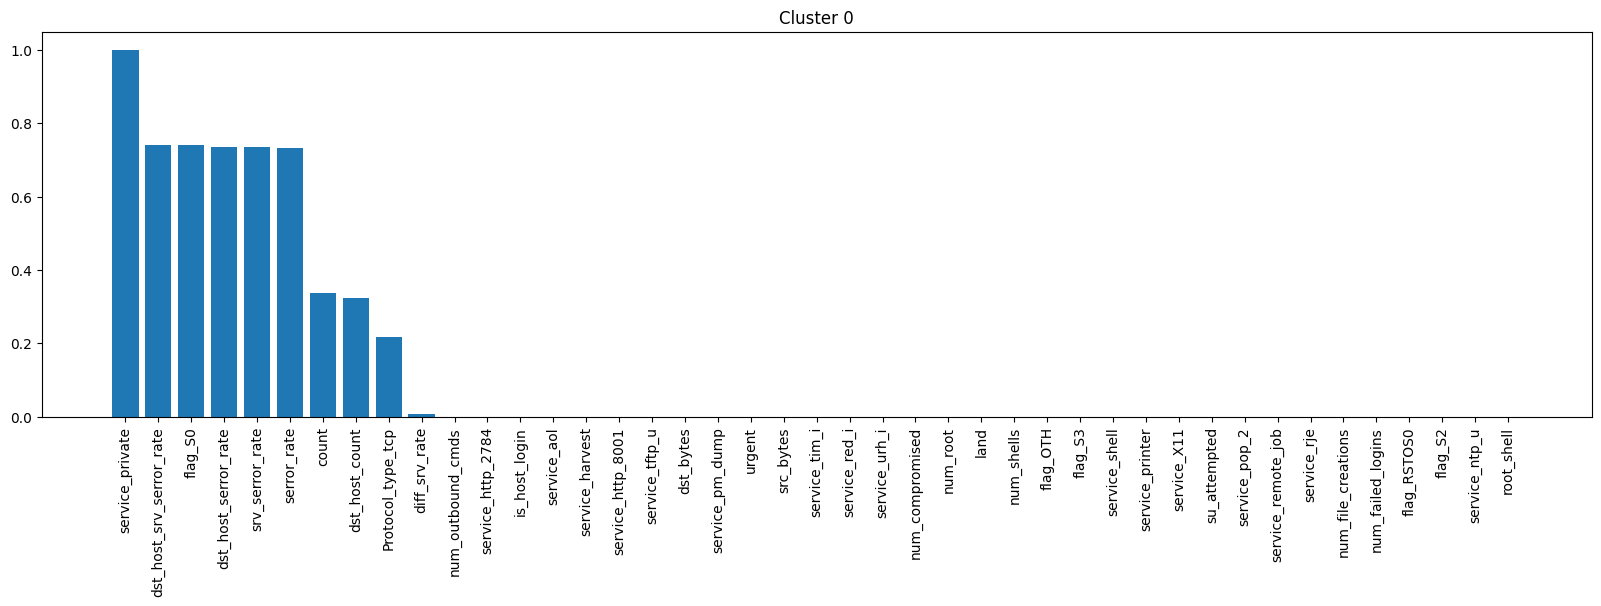

1    12025
Name: labels5, dtype: int64


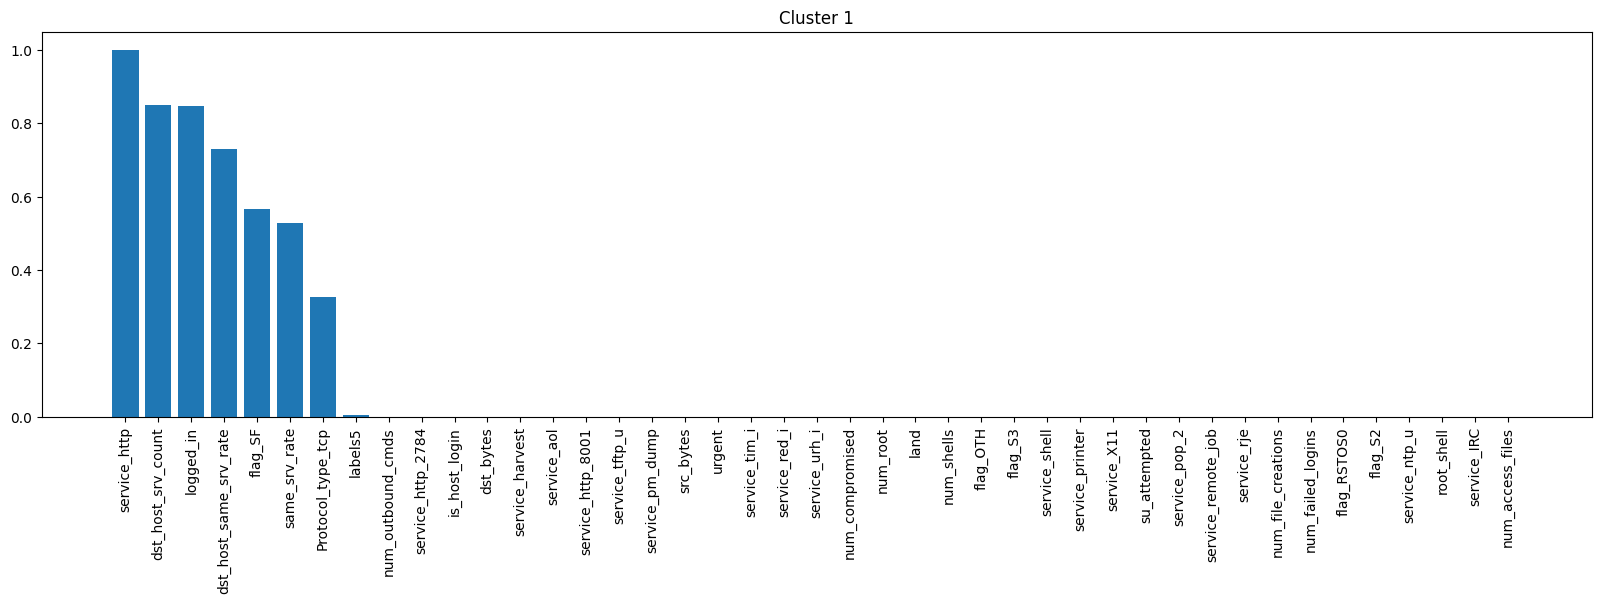

0    31359
1      189
Name: labels5, dtype: int64


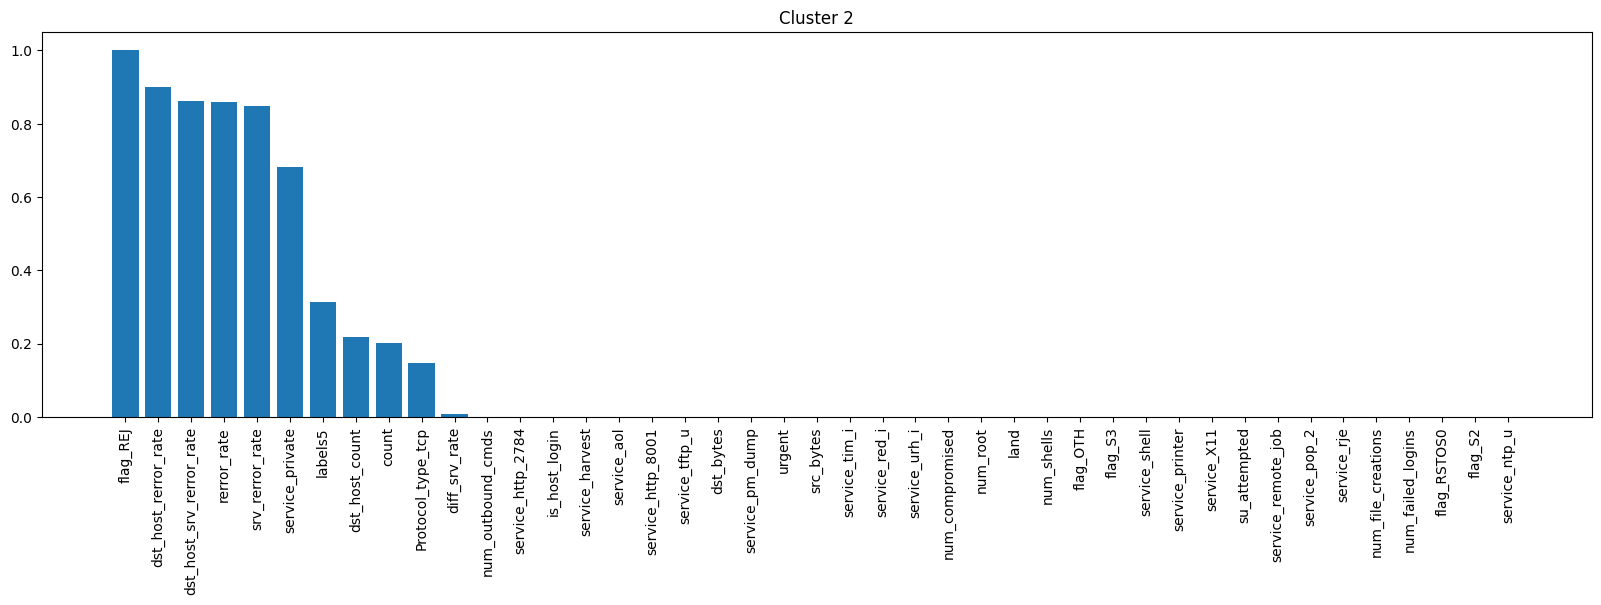

1    2123
Name: labels5, dtype: int64


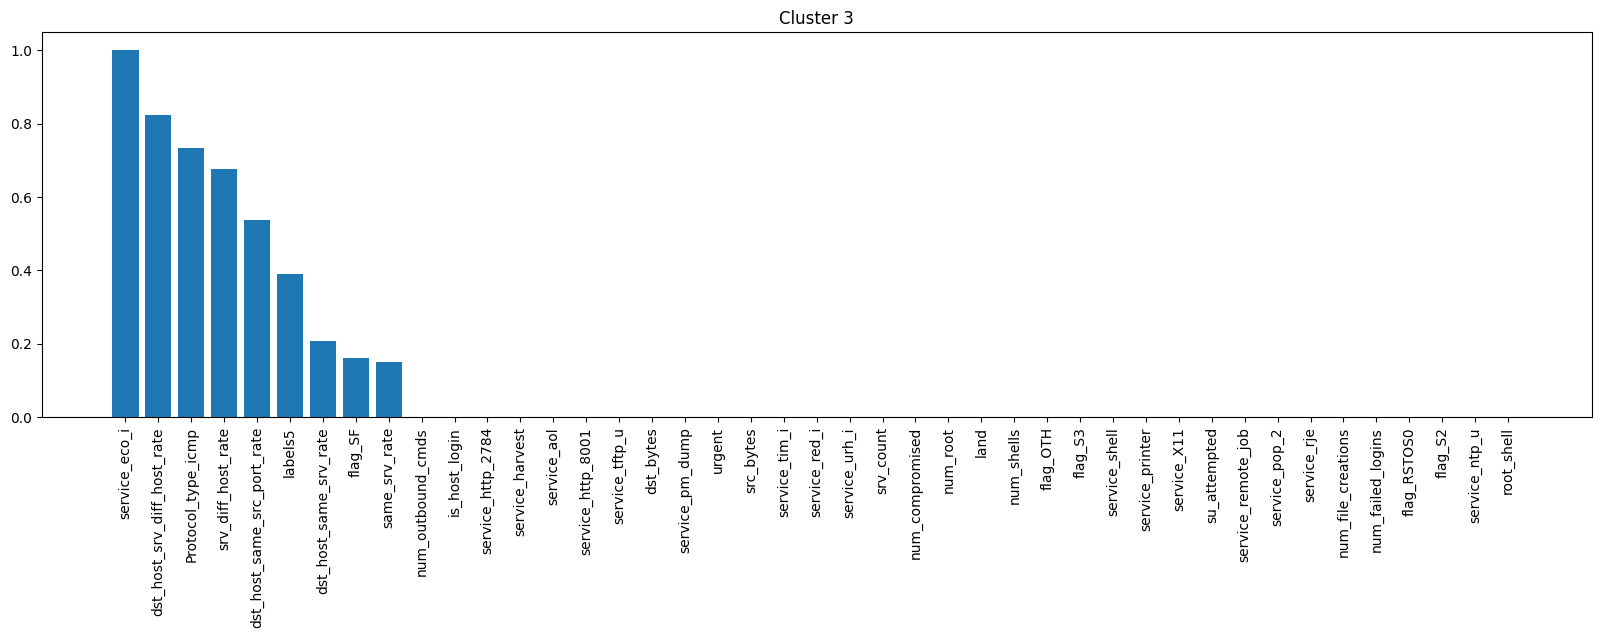

2    2456
Name: labels5, dtype: int64


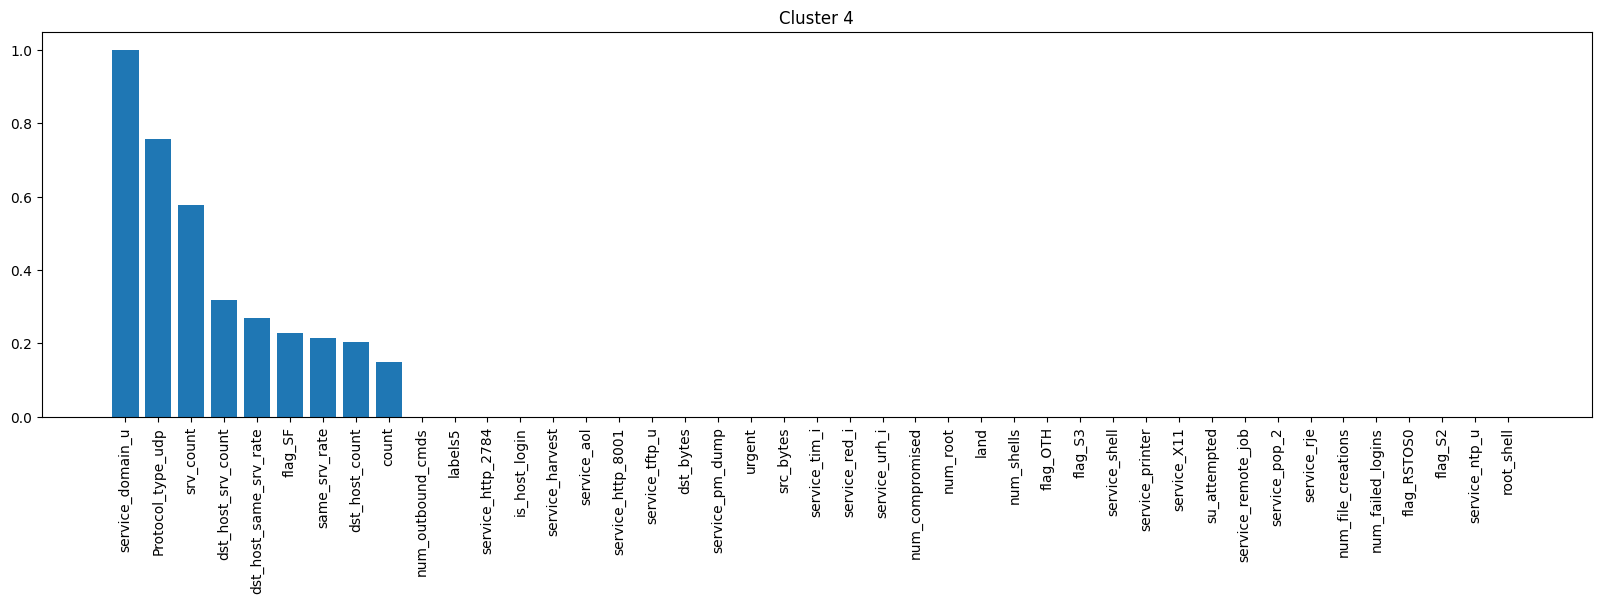

0    6236
Name: labels5, dtype: int64


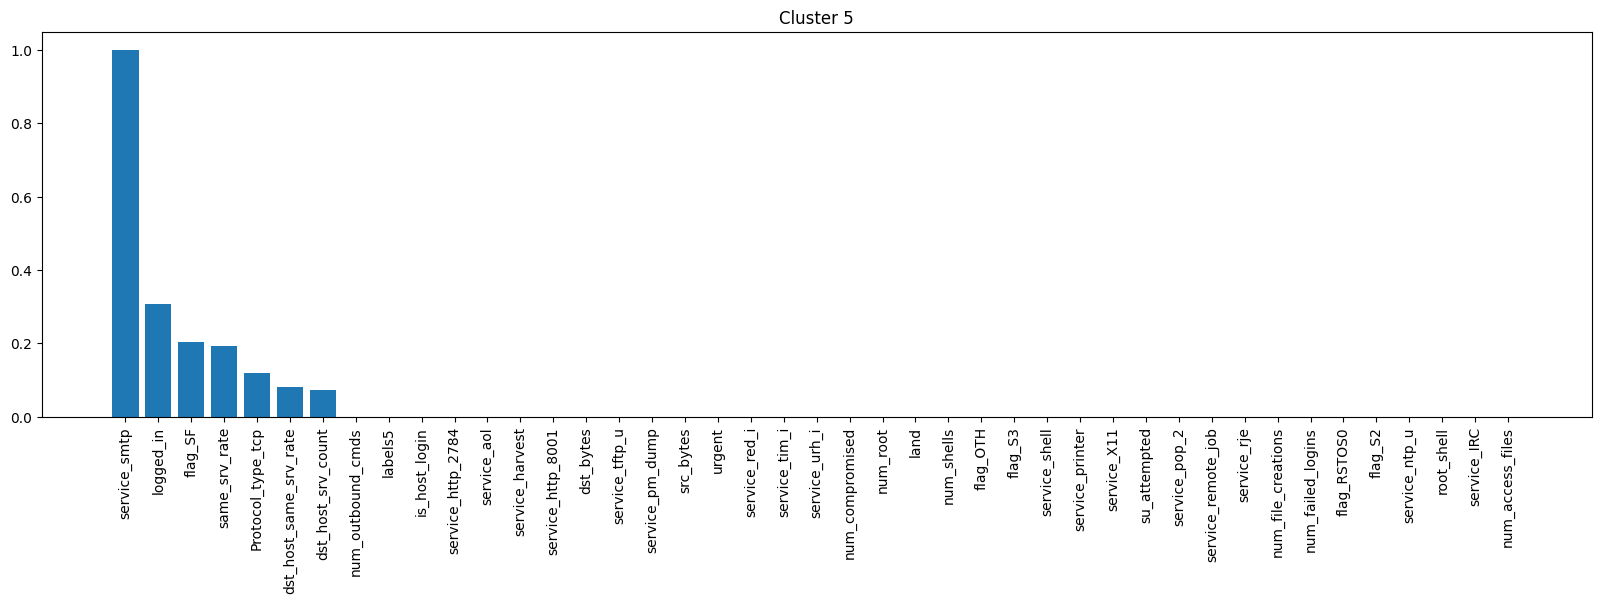

0    2725
Name: labels5, dtype: int64


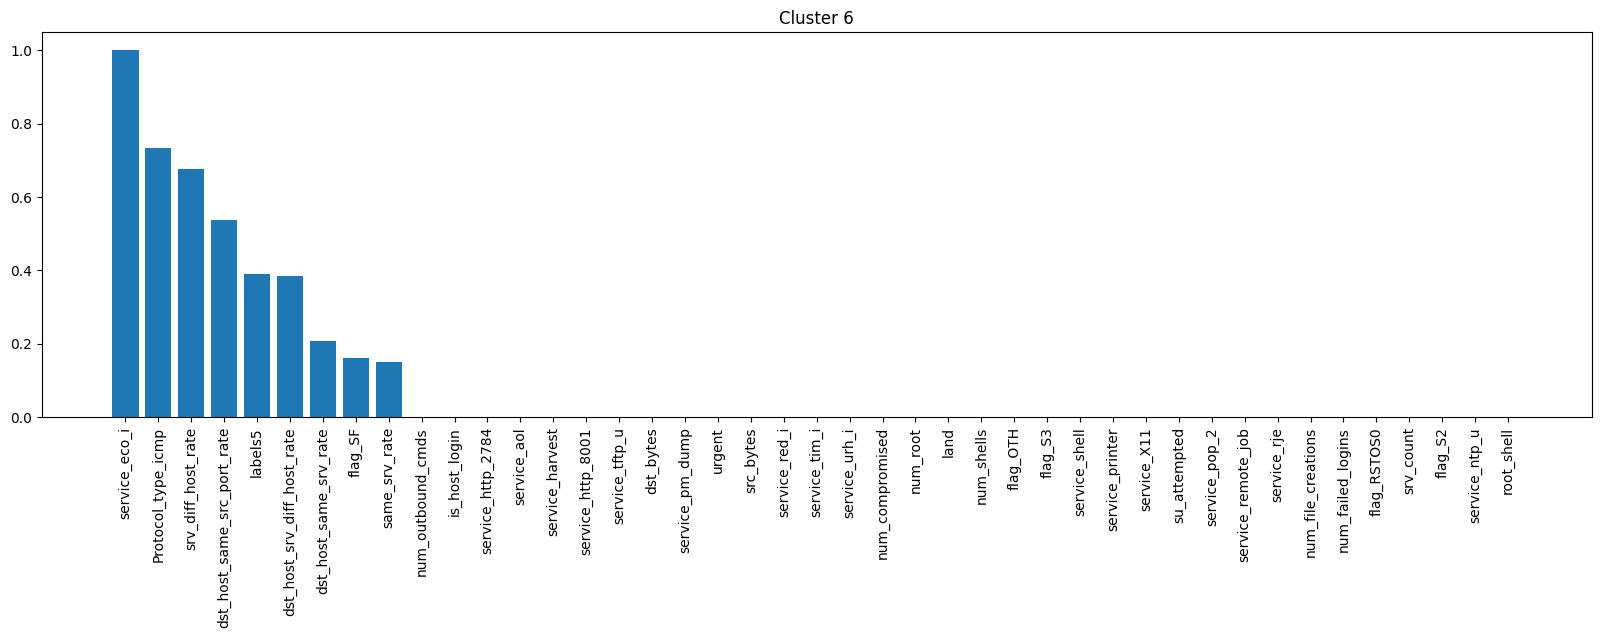

2    787
Name: labels5, dtype: int64


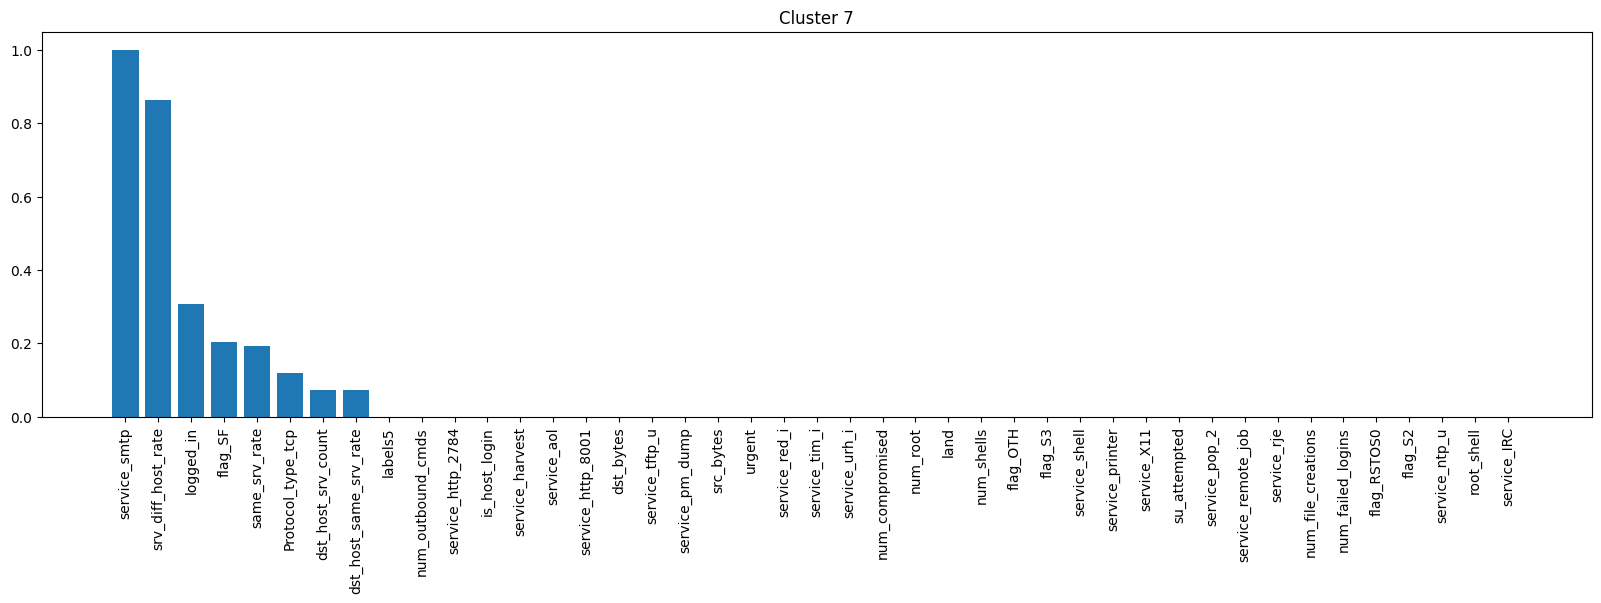

0    1874
Name: labels5, dtype: int64


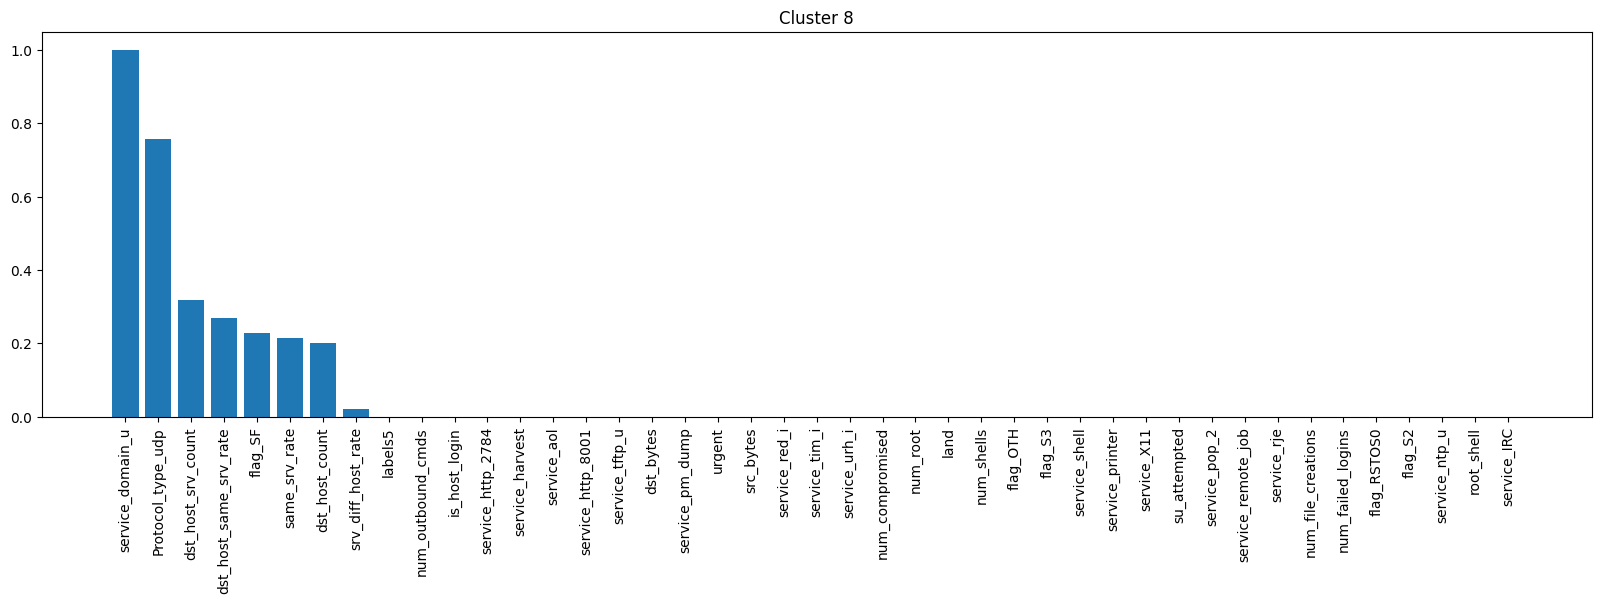

0    629
Name: labels5, dtype: int64


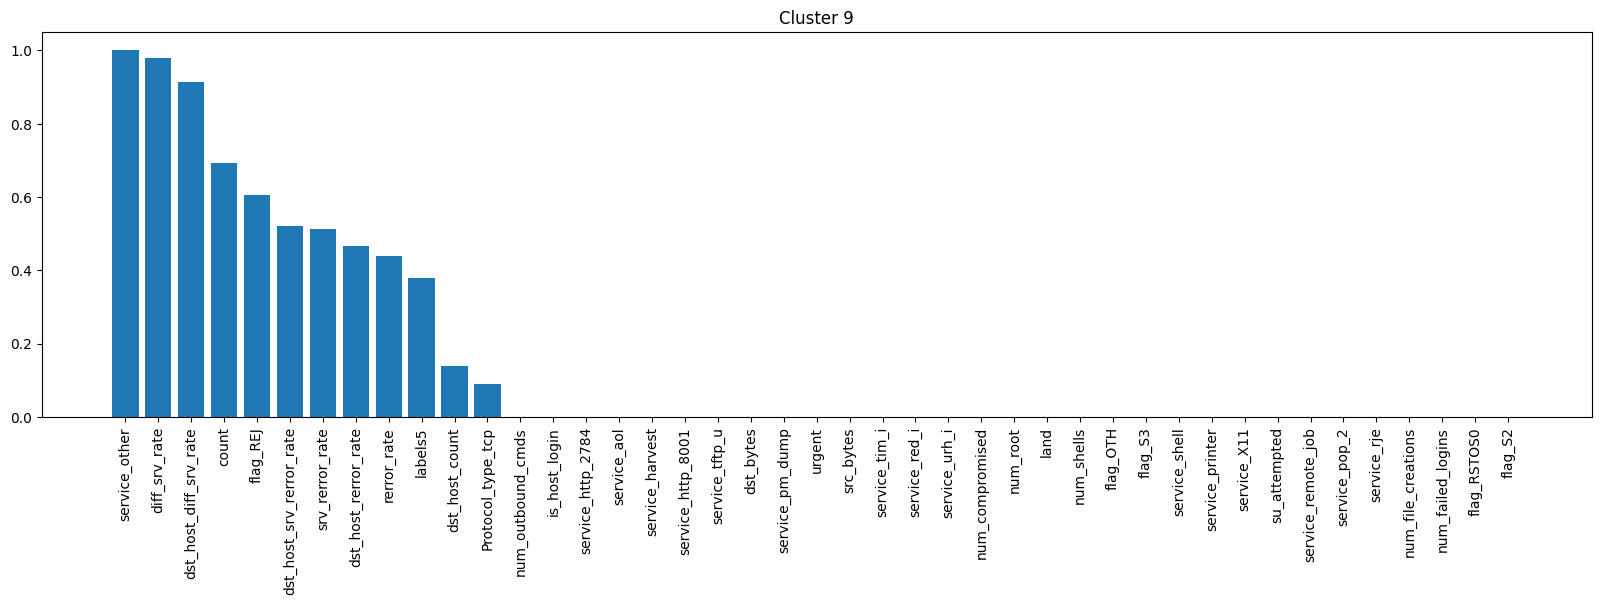

2    702
Name: labels5, dtype: int64


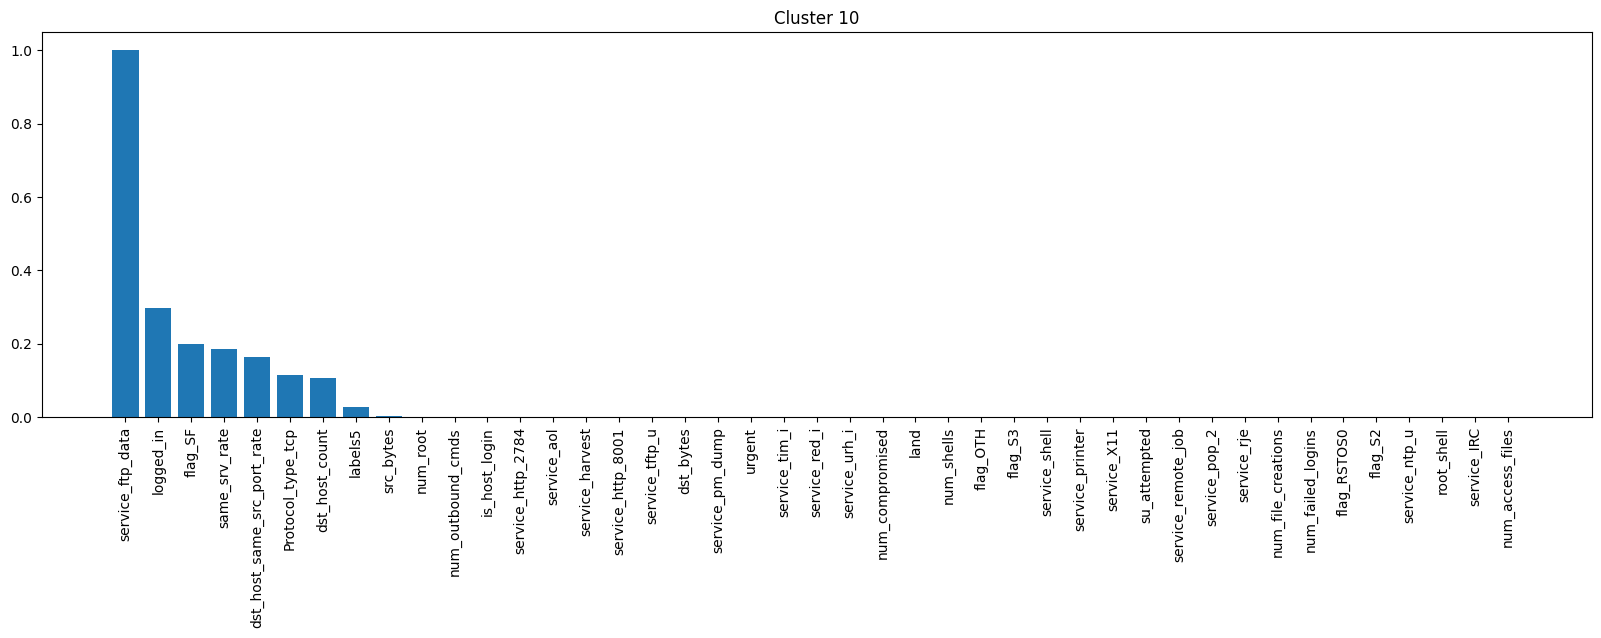

0    676
3     27
Name: labels5, dtype: int64


In [48]:
from sklearn.cluster import DBSCAN
X_full_DoS = pd.DataFrame(X_DoS, columns=DoS_df.drop(['labels2','labels5'], 1).columns)

# Fit model for full
full_dbscan = DBSCAN(eps=0.7, min_samples=600)
full_fit = full_dbscan.fit(X_train)

# # Plot biểu đồ cột cho từng cluster
temp_labels = full_dbscan.labels_
clusters = len(set(temp_labels)) - (1 if -1 in temp_labels else 0)

# Tạo dataframe tạm thời để tính số lượng record tấn công DoS hoặc không tấn công
# 0 = not attack DoS, 1 = attack DoS
temp_full_df = X_train.copy()

for i in range(clusters):
    cluster_data = temp_full_df[temp_labels == i]
    cluster_mean = cluster_data.mean().sort_values(ascending=False)
    largest_mean = cluster_mean.max()

    # Tính tỉ lệ mean
    cluster_mean_percent = (cluster_mean.head(43) / largest_mean)
    cluster_mean_percent = cluster_mean_percent.where(cluster_mean_percent > 0)
    cluster_mean_percent = cluster_mean_percent.fillna(0.0)

    # Vẽ biểu đồ cột
    plt.figure(figsize=(20, 5))
    plt.bar(cluster_mean_percent.index, cluster_mean_percent)
    plt.title(f"Cluster {i}")
    plt.xticks(rotation=90)
    plt.show()

    #Đếm số lượng normal - attacks
    temp_full_df["labels5"] = newdf["labels5"]
    cluster_data = temp_full_df[temp_labels == i]
    print(cluster_data.labels5.value_counts())

Từ biểu đồ ở trên, rút ra kết luận, với tập full, ứng dụng dbscan với eps=0.7 và min_samples=600, chưa áp dụng feature extraction sẽ có 10 cluster. Trong đó các cluster 0, 2, 3, 6, 9 là các cluster tấn công, các cluster 1, 4, 5, 7, 8, 10 là các cluster normal. Xác định cluster là tấn công hay normal dựa trên sự tương quan giữa số lượng record là normal (0) với số lượng record thuộc về lớp tấn công DoS (1)- Probe(2) - R2L(3) - U2R(4)

Build model cho DoS

In [52]:
# Fit model for DoS
DoS_dbscan = DBSCAN(eps=0.7, min_samples=600)
DoS_dbscan.fit(X_rfeDoS)
DoS_fit_predict = DoS_dbscan.fit_predict(X_DoS_test)
print(set(DoS_fit_predict))

{0, 1, 2, 3, -1}


In [53]:
pd.crosstab(Y_DoS_test, DoS_fit_predict, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,-1,0,1,2,3
Actual attacks,,,,,
0,4637,0,2545,2529,0
1,4834,1840,0,6,780


Build model cho Probe

In [55]:
# Fit model for Probe
Probe_dbscan = DBSCAN(eps=0.7, min_samples=600)
Probe_dbscan.fit(X_rfeProbe)
Probe_fit_predict = Probe_dbscan.fit_predict(X_Probe_test)
print(set(Probe_fit_predict))

{0, -1}


In [56]:
pd.crosstab(Y_Probe_test, Probe_fit_predict, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,-1,0
Actual attacks,,
0,3995,5716
2,2421,0


Build model cho R2L

In [57]:
# Fit model for R2L
R2L_dbscan = DBSCAN(eps=0.7, min_samples=600)
R2L_dbscan.fit(X_rfeR2L)
R2L_fit_predict = R2L_dbscan.fit_predict(X_R2L_test)
print(set(R2L_fit_predict))

{0, -1}


In [58]:
pd.crosstab(Y_R2L_test, R2L_fit_predict, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,-1,0
Actual attacks,,
0,4454,5257
3,2885,0


Build model cho U2R

In [59]:
# Fit model for U2R
U2R_dbscan = DBSCAN(eps=0.7, min_samples=600)
U2R_dbscan.fit(X_rfeU2R)
U2R_fit_predict = U2R_dbscan.fit_predict(X_U2R_test)
print(set(U2R_fit_predict))

{0, -1}


In [60]:
pd.crosstab(Y_U2R_test, U2R_fit_predict, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,-1,0
Actual attacks,,
0,4435,5276
4,67,0


# END: DBSCAN

# START: CNN MODEL

In [81]:
# Sử dụng X_train và X_test là bộ dữ liệu đã qua Scaler và OHE
# Y_train là nhãn: normal(0) - DoS (1)- Probe(2) - R2L(3) - U2R(4)
X_train_multi = X_train.copy()
print(X_train_multi)
y_train_multi = pd.DataFrame(newdf.labels5, columns=["labels5"])
y_test_multi = pd.DataFrame(newdf_test.labels5, columns=["labels5"])
print(y_train_multi.shape)

        duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0      -0.110249  -0.007679  -0.004919 -0.014089       -0.089486 -0.007736   
1      -0.110249  -0.007737  -0.004919 -0.014089       -0.089486 -0.007736   
2      -0.110249  -0.007762  -0.004919 -0.014089       -0.089486 -0.007736   
3      -0.110249  -0.007723  -0.002891 -0.014089       -0.089486 -0.007736   
4      -0.110249  -0.007728  -0.004814 -0.014089       -0.089486 -0.007736   
...          ...        ...        ...       ...             ...       ...   
125968 -0.110249  -0.007762  -0.004919 -0.014089       -0.089486 -0.007736   
125969 -0.107178  -0.007744  -0.004883 -0.014089       -0.089486 -0.007736   
125970 -0.110249  -0.007382  -0.004823 -0.014089       -0.089486 -0.007736   
125971 -0.110249  -0.007762  -0.004919 -0.014089       -0.089486 -0.007736   
125972 -0.110249  -0.007737  -0.004919 -0.014089       -0.089486 -0.007736   

             hot  num_failed_logins  logged_in  num_compromised

In [82]:
# N19DCAT015 - Le Ngoc Kim Duyen
# Mã hóa nhị phân cho các nhãn ở y_train_multi
from sklearn.preprocessing import LabelBinarizer
y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_test_multi = LabelBinarizer().fit_transform(y_test_multi)
print(y_train_multi)
print(y_test_multi)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 ...
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 ...
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]


In [92]:
# Tạo X và y cho model
X_cnn_train = X_train_multi
X_cnn_test = X_test.copy()
X_cnn_test = X_cnn_test.copy()

y_cnn_train = y_train_multi
y_cnn_test = y_test_multi

Reshape dữ liệu

Do CNN thường được ứng dụng trong phân tích ảnh nên thường sẽ có 3 chiều (3 dimensions: width, height, and depth). Mà dữ liệu từ NSL-KDD chỉ có 2 chiều row (record) và column (attribute - feature) nên cần thêm 1 chiều nữa để sử dụng

In [93]:
X_cnn_train=X_cnn_train.to_numpy()
X_cnn_train = np.reshape(X_cnn_train, (X_cnn_train.shape[0], X_cnn_train.shape[1], 1))
X_cnn_train.shape

(125973, 122, 1)

In [94]:
X_test

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S2,flag_S3,flag_SF,flag_SH,service_urh_i,service_harvest,service_red_i,service_aol,service_http_2784,service_http_8001
0,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.154113,0.005473,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.155534,-0.021946,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.154823,-0.021988,-0.096189,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155534,-0.020309,-0.081202,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
22540,-0.155534,-0.021318,-0.052690,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
22541,-0.155534,0.093373,0.294926,-0.017624,-0.059104,-0.019459,2.040705,-0.143999,1.123125,0.121069,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
22542,-0.155534,-0.021899,-0.094917,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
X_cnn_test

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S2,flag_S3,flag_SF,flag_SH,service_urh_i,service_harvest,service_red_i,service_aol,service_http_2784,service_http_8001
0,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.155534,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.154113,0.005473,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.155534,-0.021946,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.154823,-0.021988,-0.096189,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,-1.392705,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155534,-0.020309,-0.081202,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
22540,-0.155534,-0.021318,-0.052690,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,1.123125,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
22541,-0.155534,0.093373,0.294926,-0.017624,-0.059104,-0.019459,2.040705,-0.143999,1.123125,0.121069,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0
22542,-0.155534,-0.021899,-0.094917,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,...,-0.025803,-0.105681,0.718027,-0.056997,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
X_cnn_test=X_cnn_test.to_numpy()
X_cnn_test = np.reshape(X_cnn_test, (X_cnn_test.shape[0], X_cnn_test.shape[1], 1))
X_cnn_test.shape

(22544, 122, 1)

Build CNN model

In [98]:
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.models import Sequential
model = Sequential([
    # Input layer và first layer với 50 neurons
    Conv1D(32, 3, padding="same",input_shape = (X_cnn_train.shape[1], 1), activation='relu'),
    MaxPool1D(pool_size=(4)),
    Dropout(0.2),
    Conv1D(32, 3, padding="same", activation='relu'),
    MaxPool1D(pool_size=(4)),
    Dropout(0.2),
    Flatten(),
    Dense(units=50),
    # Output layer với softmax
    Dense(units=5,activation='softmax')
])


In [99]:
from keras import callbacks
from keras.callbacks import CSVLogger
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpointer = callbacks.ModelCheckpoint("./ckpt/checkpoint-{epoch:03d}.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger('training_set_iranalysis.csv',separator=',', append=False)

In [100]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 122, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 32)             0

In [101]:
# Train model với epoch=50
history = model.fit(X_cnn_train, y_cnn_train, epochs=50, batch_size=5000,callbacks=[checkpointer,csv_logger],validation_split=0.2)

Epoch 1/50
20/21 [===========================>..] - ETA: 0s - loss: 1.1991 - accuracy: 0.5168
Epoch 1: val_accuracy improved from -inf to 0.74554, saving model to ./ckpt\checkpoint-001.hdf5
21/21 [==============================] - 6s 238ms/step - loss: 1.1960 - accuracy: 0.5183 - val_loss: 0.8064 - val_accuracy: 0.7455
Epoch 2/50
20/21 [===========================>..] - ETA: 0s - loss: 0.7255 - accuracy: 0.7698
Epoch 2: val_accuracy improved from 0.74554 to 0.90181, saving model to ./ckpt\checkpoint-002.hdf5
21/21 [==============================] - 5s 227ms/step - loss: 0.7245 - accuracy: 0.7703 - val_loss: 0.5182 - val_accuracy: 0.9018
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.8669
Epoch 3: val_accuracy improved from 0.90181 to 0.93138, saving model to ./ckpt\checkpoint-003.hdf5
21/21 [==============================] - 5s 225ms/step - loss: 0.5032 - accuracy: 0.8669 - val_loss: 0.3306 - val_accuracy: 0.9314
Epoch 4/50
20/21 [=============

In [102]:
# Predicting trên test set
test_results = model.evaluate(X_cnn_test, y_cnn_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

705/705 [==============================] - 1s 2ms/step - loss: 1.5568 - accuracy: 0.7265
Test results - Loss: 1.556840181350708 - Accuracy: 72.64904379844666%


In [104]:
from keras import models
import os

checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
print(checkpoints)
latest_checkpoint = max(checkpoints, key=os.path.getctime)
model = models.load_model(latest_checkpoint)

loss, accuracy = model.evaluate(X_cnn_test, y_cnn_test)   
print('loss: ' + str(loss), 'accuracy:' + str(accuracy))

['./ckpt/checkpoint-001.hdf5', './ckpt/checkpoint-002.hdf5', './ckpt/checkpoint-003.hdf5', './ckpt/checkpoint-004.hdf5', './ckpt/checkpoint-005.hdf5', './ckpt/checkpoint-006.hdf5', './ckpt/checkpoint-007.hdf5', './ckpt/checkpoint-008.hdf5', './ckpt/checkpoint-009.hdf5', './ckpt/checkpoint-010.hdf5', './ckpt/checkpoint-011.hdf5', './ckpt/checkpoint-012.hdf5', './ckpt/checkpoint-014.hdf5', './ckpt/checkpoint-015.hdf5', './ckpt/checkpoint-017.hdf5', './ckpt/checkpoint-018.hdf5', './ckpt/checkpoint-019.hdf5', './ckpt/checkpoint-020.hdf5', './ckpt/checkpoint-021.hdf5', './ckpt/checkpoint-022.hdf5', './ckpt/checkpoint-023.hdf5', './ckpt/checkpoint-024.hdf5', './ckpt/checkpoint-025.hdf5', './ckpt/checkpoint-027.hdf5', './ckpt/checkpoint-029.hdf5', './ckpt/checkpoint-033.hdf5', './ckpt/checkpoint-034.hdf5', './ckpt/checkpoint-035.hdf5', './ckpt/checkpoint-036.hdf5', './ckpt/checkpoint-037.hdf5', './ckpt/checkpoint-039.hdf5', './ckpt/checkpoint-040.hdf5', './ckpt/checkpoint-041.hdf5', './ckpt/c

In [107]:
y_pred = model.predict(X_cnn_test)
y_pred

705/705 [==============================] - 1s 2ms/step


array([[8.3654886e-05, 9.9990499e-01, 9.8899245e-06, 2.9941754e-07,
        1.0856473e-06],
       [1.4967774e-04, 9.9982917e-01, 1.9020279e-05, 4.6508339e-07,
        1.6854915e-06],
       [8.3145702e-01, 1.4960150e-01, 1.2120655e-02, 4.8651793e-03,
        1.9555942e-03],
       ...,
       [8.4221601e-01, 1.4777538e-01, 2.0839280e-04, 7.4212044e-03,
        2.3789688e-03],
       [9.9941337e-01, 5.2679945e-05, 5.1908102e-04, 6.7131837e-06,
        8.0789005e-06],
       [2.7180710e-01, 7.0806378e-01, 1.9783814e-02, 1.0268773e-05,
        3.3503451e-04]], dtype=float32)

In [108]:
y_pred=np.argmax(y_pred, axis=1)
y_cnn_test=np.argmax(y_cnn_test, axis=1)

# END: CNN MODEL

# START: CONFUSION MATRIX

Sử dụng confusion matrix để đánh giá

Không thể sử dụng confusion matrix để đánh giá DBSCAN vì DBSCAN là thuật toán học không giám sát

Có thể sử dụng confusion matrix để đánh giá mô hình CNN

In [109]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_cnn_test, y_pred)
cm

array([[9440,   71,  200,    0,    0],
       [1661, 5759,   40,    0,    0],
       [ 822,  409, 1190,    0,    0],
       [2661,  179,   28,   17,    0],
       [  62,    5,    0,    0,    0]], dtype=int64)

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
cm_df = pd.DataFrame(cm,
                     index = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'], 
                     columns = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])

        TPR       ACC       PPV       NPV       FNR       FPR       FDR  \
0  0.972094  0.757053  0.644545  0.965688  0.027906  0.405673  0.355455   

        FOR  F1_score  
0  0.034312  0.775137  
        TPR       ACC       PPV       NPV       FNR      FPR       FDR  \
0  0.771984  0.895094  0.896622  0.894485  0.228016  0.04402  0.103378   

        FOR  F1_score  
0  0.105515  0.829648  
        TPR       ACC       PPV      NPV       FNR       FPR       FDR  \
0  0.491532  0.933508  0.816187  0.94162  0.508468  0.013318  0.183813   

       FOR  F1_score  
0  0.05838   0.61356  
        TPR       ACC  PPV       NPV       FNR  FPR  FDR       FOR  F1_score
0  0.005893  0.872782  1.0  0.872686  0.994107  0.0  0.0  0.127314  0.011716
   TPR       ACC  PPV       NPV  FNR  FPR  FDR       FOR  F1_score
0  0.0  0.997028  NaN  0.997028  1.0  0.0  NaN  0.002972       NaN


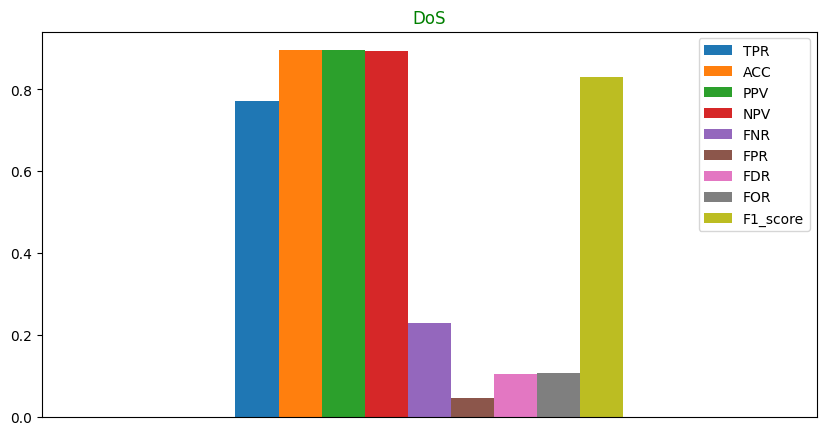

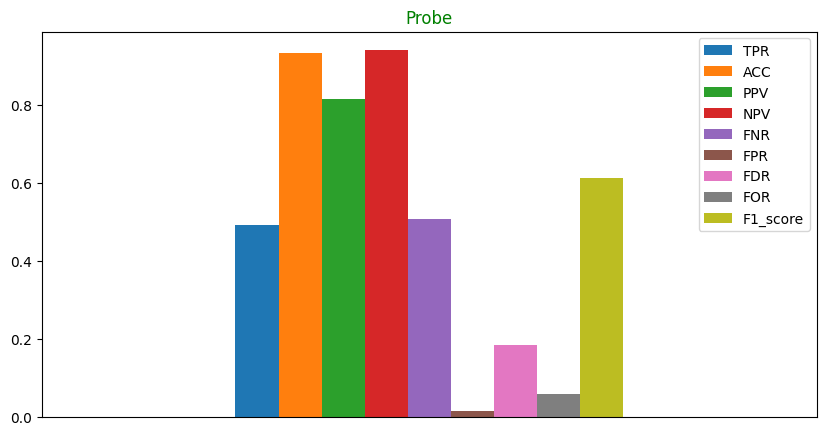

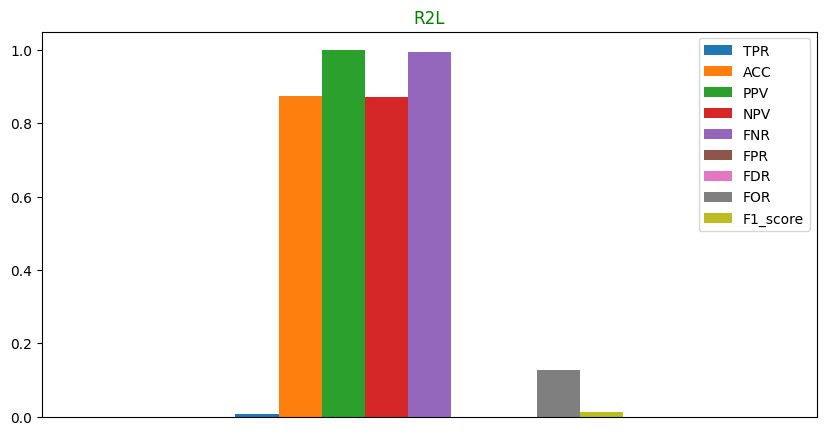

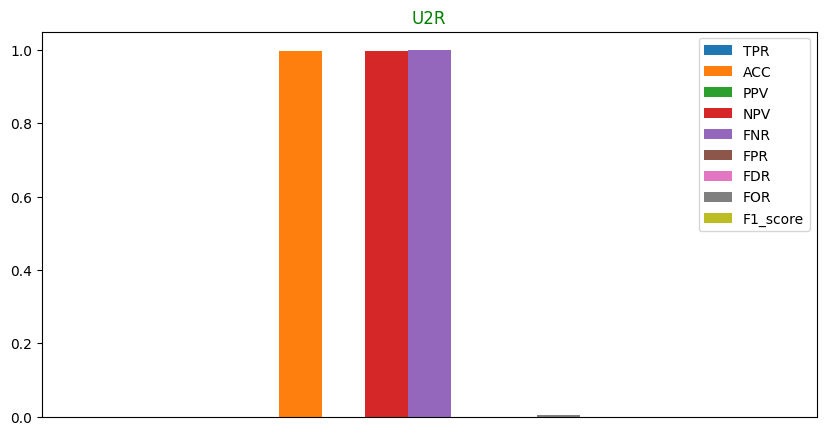

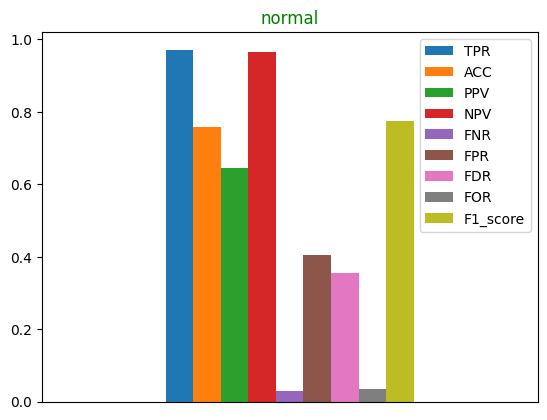

In [111]:
normal = {}
DoS = {}
Probe = {}
R2L = {}
U2R = {}

list_label = [normal, DoS, Probe, R2L, U2R]
sum_matrix = sum(sum(cm))
for c in range(len(list_label)):
    tp = cm[c,c]
    fp = sum(cm[:,c]) - cm[c,c]
    fn = sum(cm[c,:]) - cm[c,c]
    # tn = sum(np.delete(sum(cm)-cm[c,:],c))
    tn = sum_matrix - tp - fp - fn
    list_label[c]['TPR'] = tp/(tp+fn)
    # recall = tp/(tp+fn)
    list_label[c]['ACC'] = (tp+tn)/(tp+fp+fn+tn)
    list_label[c]['PPV'] = tp/(tp+fp)
    list_label[c]['NPV'] = tn/(tn+fn)
    list_label[c]['FNR'] = 1 - list_label[c]['TPR']
    list_label[c]['FPR'] = fp/(fp+tn)
    list_label[c]['FDR'] = 1 - list_label[c]['PPV']
    list_label[c]['FOR'] = 1 - list_label[c]['NPV']
    list_label[c]['F1_score'] = (2*list_label[c]['PPV']*list_label[c]['TPR'])/(list_label[c]['PPV'] + list_label[c]['TPR'])
list_tt = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
for c in range(len(list_label)):

  normal = [list_label[c]]
  df = pd.DataFrame(normal)
  print(df)
  df.plot(kind='bar')
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.title(label=list_tt[c], color="green")
  plt.xlabel('') 
  plt.xticks([])
  plt.figure(1)
  plt.plot()

# END: CONFUSION MATRIX